#### MOUNT DRIVE

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### INSTALL DEPENDENCIES AND IMPORT LIBRARIES

In [2]:
!pip install transformers
!pip install datasets
!pip install rouge-score
!pip install sentencepiece
!pip install sacrebleu==1.5.1
!pip install sacremoses

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 98.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 20.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 15.8 MB/s eta 0:00:0

#### IMPORT LIBRARIES

In [3]:
import pandas as pd
import datasets
from datasets import Metric, load_dataset, load_metric, Dataset

import torch
from torch import optim
from torch.utils.data import DataLoader

import transformers
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

torch.cuda.empty_cache()

In [4]:
!git clone https://github.com/nelson-nsc/COMP0087-NLP-project.git

Cloning into 'ucl-nlp'...
remote: Enumerating objects: 186, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 186 (delta 26), reused 33 (delta 19), pack-reused 137
Receiving objects: 100% (186/186), 7.98 MiB | 9.67 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [5]:
%cd /content/COMP0087-NLP-project
import evaluation
%cd ..

/content/ucl-nlp
/content


#### LOAD TEST DATA

In [6]:
test_df = pd.read_csv('/content/COMP0087-NLP-project/data/conala-hq-marian/hq_test.csv')

#### TOKENIZER

In [7]:
# get the marian tokenizer
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-nl", use_fast = True)

#### MIXED DATA TRAINED MODEL

In [8]:
# hq + mined model
mix_model = AutoModelForSeq2SeqLM.from_pretrained("/content/drive/MyDrive/trained_models/fine_tuned_marian_hq_plus_mined").to('cuda')

#### AUGMENTED DATA TRAINED MODEL

In [9]:
# model trained on augmented data
aug_model = AutoModelForSeq2SeqLM.from_pretrained("/content/drive/MyDrive/trained_models/fine_tuned_marian_aug_data").to('cuda')

#### CODE GENERATION

In [10]:
# define a function that can do code generation on a batch
def generate_response(NL, model, tokenizer):

    inputs = tokenizer(NL, padding='max_length', truncation=True, max_length=512, return_tensors="pt")

    input_ids = inputs.input_ids.to('cuda')
    attention_mask = inputs.attention_mask.to('cuda')

    output = model.generate(input_ids=input_ids, attention_mask=attention_mask)[0]

    output_str = tokenizer.decode(output, skip_special_tokens=True)

    return output_str

#### EVALUATION

In [12]:
evaluator = evaluation.CodeGenerationEvaluator(tokenizer, 'cuda', smooth_bleu=True)

/content/ucl-nlp/evaluation.py:32: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  self.sacre_bleu: Metric = load_metric('sacrebleu')


In [13]:
def get_preds(test_df, model, tokenizer):
  results = []
  for i in range(len(test_df)):
    row = test_df.iloc[i]

    output_str = generate_response(row['intent'], model, tokenizer)

    results.append(output_str)

  return results

In [14]:
def get_bleu_score(test_df, tokenizer, model):
  bleu = 0

  preds = get_preds(test_df, model, tokenizer)  # get predicted responses

  for i in range(len(preds)):

    ref = test_df['snippet'][i]                       # actual snippet
    pred = preds[i]                                   # predicted snippet

    if pred is not None and pred != "":

      if ref is not None and ref != "":
       
        metrics = evaluator.evaluate([pred], [ref])

        bleu += metrics['BLEU']
  
  return bleu/len(preds)

#### EVALUATE THE MODELS

In [15]:
models = [mix_model, aug_model]

bleu_scores = [get_bleu_score(test_df, tokenizer, model) for model in models]

/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (512) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [16]:
bleu_scores

[33.43752674771536, 37.81887503587737]

#### CHECK PERFORMANCE ON DIFFERENT LENGTH OF SNIPPETS

In [ ]:
## check performance on differnet lengths of snippets
lengths = [0, 10, 20, 30, 40, 50, 60, 70]
results = []
yes = lambda x, l: len(x) > l

for l in lengths:
  idx = []

  for i in range(len(test_df)):
    if yes(test_df.iloc[i]['snippet'], l):
      idx.append(i)

  df = test_df.iloc[idx]
  df.reset_index(drop=True, inplace=True)
  
  results.append(get_bleu_score(df, tokenizer, aug_model))

/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (512) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
results

[37.81887503587737,
 37.409753269504954,
 35.711178050842165,
 34.08758073112004,
 30.829485944845583,
 31.40210217757424,
 29.67194174556461,
 31.25947692686221]

Text(0.5, 0, 'number of characters in snippet')

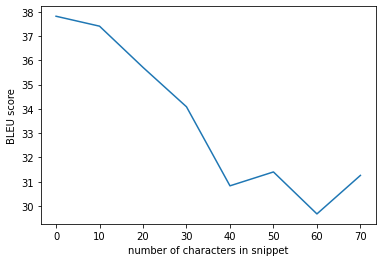

In [ ]:
plt.plot(lengths, results)
plt.ylabel('BLEU score')
plt.xlabel('number of characters in snippet')

#### TEST IT OUT

In [18]:
generate_response('check if a variable is an int in python', aug_model, tokenizer)

'isinstance(s, int)'